In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip3 install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip3 install --quiet --upgrade jsonschema
    !pip3 install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

In [3]:
print(scvi.__version__)

0.11.0


## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on [data loading](data_loading.ipynb) for more examples.

* Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input. 

</div>

In [4]:
adata = scvi.data.heart_cell_atlas_subsampled()

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18641 cells, 26662 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [5]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

In [6]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [7]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=1200, 
    subset=True, 
    layer="counts", 
    flavor="seurat_v3",
    batch_key="cell_source"
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [8]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [87]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [88]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [89]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 2/400:   0%|          | 1/400 [00:02<16:45,  2.52s/it, loss=321, v_num=1]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [392]:
def get_var_value(filename="varstore.dat"):
    with open(filename, "a+") as f:
        f.seek(0)
        val = int(f.read() or 0) + 1
        f.seek(0)
        f.truncate()
        f.write(str(val))
        return val
count = get_var_value()


In [393]:
model.save("my_model" + str(count) + "/")


In [9]:
#model = scvi.model.SCVI.load("my_model" + str(count) + "/", adata, use_gpu=False)
model = scvi.model.SCVI.load("my_model1/", adata, use_gpu=False)


INFO     Using data from adata.layers["counts"]                                              


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              




## Obtaining model outputs

In [10]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [11]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [12]:
import numpy as np
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

fibroblast = adata[adata.obs.cell_type == "Fibroblast"]
smooth = adata[adata.obs.cell_type == "Smooth_muscle_cells"]
myeloid = adata[adata.obs.cell_type == "Myeloid"]
f = model.get_normalized_expression(fibroblast, return_mean=False)
s = model.get_normalized_expression(smooth, return_mean=False)
m = model.get_normalized_expression(myeloid, return_mean=False)


INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


In [13]:
#initialize storage matrices with model1 data
DCN= []
for i in f["DCN"]:
    DCN.append([i])
GSN = []
for i in f["GSN"]:
    GSN.append([i])
PDGFRA = []
for i in f["PDGFRA"]:
    PDGFRA.append([i])

MYH11 = []
for i in s["MYH11"]:
    MYH11.append([i])
TAGLN = []
for i in s["TAGLN"]:
    TAGLN.append([i])
ACTA2= []
for i in s["ACTA2"]:
    ACTA2.append([i])

CD14 = []
for i in m["CD14"]:
    CD14.append([i])
C1QA = []
for i in m["C1QA"]:
    C1QA.append([i])
CD68 = []
for i in m["CD68"]:
    CD68.append([i])


In [25]:
print(np.mean(np.array(CD68)))

0.0018328326199681692


In [26]:
# now loop to fill in each matrix with all models' data
mD = []
sD = []
mG = []
sG = []
mP = []
sP = []
mT = []
sT = []
mM = []
sM = []
mA = []
sA = []
mCD1= []
sCD1= []
mC1= []
sC1= []
mCD6= []
sCD6= []

for i in range(1, 37):
    DCN = []
    GSN = []
    PDGFRA = []
    MYH11 = []
    ACTA2= []
    CD14 = []
    C1QA = []
    CD68 = []
    
    model = scvi.model.SCVI.load("my_model" + str(i) + "/", adata, use_gpu=False)
    latent = model.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    adata.layers["scvi_normalized"] = model.get_normalized_expression(
        library_size=10e4
    )

    fibroblast = adata[adata.obs.cell_type == "Fibroblast"]
    smooth = adata[adata.obs.cell_type == "Smooth_muscle_cells"]
    myeloid = adata[adata.obs.cell_type == "Myeloid"]
    f = model.get_normalized_expression(fibroblast, return_mean=False)
    s = model.get_normalized_expression(smooth, return_mean=False)
    m = model.get_normalized_expression(myeloid, return_mean=False)
    
    for i in range(0, len(f["DCN"])): 
        DCN.append(f["DCN"][i])
    for i in range(0, len(f["GSN"])): 
        GSN.append(f["GSN"][i])
    for i in range(0, len(f["PDGFRA"])): 
        PDGFRA.append(f["PDGFRA"][i])
    
    for i in range(0, len(s["MYH11"])): 
        MYH11.append(s["MYH11"][i])
    for i in range(0, len(s["TAGLN"])): 
        TAGLN.append(s["TAGLN"][i])
    for i in range(0, len(s["ACTA2"])): 
        ACTA2.append(s["ACTA2"][i])
    
    for i in range(0, len(m["CD14"])): 
        CD14.append(m["CD14"][i])
    for i in range(0, len(m["C1QA"])): 
        C1QA.append(m["C1QA"][i])
    for i in range(0, len(m["CD68"])): 
        CD68.append(m["CD68"][i])
        
    #calculate mean/sd across all cells in each run and add to respective scatters
    mCD6.append(np.mean(np.array(CD68)))
    sCD6.append(np.std(np.array(CD68)))
    mCD1.append(np.mean(np.array(CD14)))
    sCD1.append(np.std(np.array(CD14)))
    mC1.append(np.mean(np.array(C1QA)))
    sC1.append(np.std(np.array(C1QA)))
    mD.append(np.mean(np.array(DCN)))
    sD.append(np.std(np.array(DCN)))
    mM.append(np.mean(np.array(MYH11)))
    sM.append(np.std(np.array(MYH11)))
    mA.append(np.mean(np.array(ACTA2)))
    sA.append(np.std(np.array(ACTA2)))
    mT.append(np.mean(np.array(TAGLN)))
    sT.append(np.std(np.array(TAGLN)))
    mG.append(np.mean(np.array(GSN)))
    sG.append(np.std(np.array(GSN)))
    mP.append(np.mean(np.array(PDGFRA)))
    sP.append(np.std(np.array(PDGFRA)))
    
                   
    


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Using data from adata.layers["counts"]             

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Using data from adata.layers["counts"]                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch             

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Using data from adata.layers["counts"]             

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Using data from adata.layers["counts"]                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs', 'cont_covs']                                                            
INFO     Successfully registered anndata object containing 18641 cells, 1200 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              
INFO     Received view of anndata, making copy.                                              


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


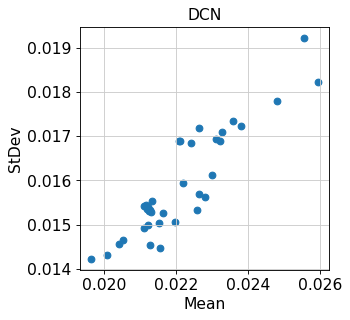

<Figure size 320x320 with 0 Axes>

In [36]:
#biological heterogeneity
import matplotlib.pyplot as plt 
plt.scatter(mD, sD)

plt.title("DCN")
plt.ylabel("StDev")
plt.xlabel("Mean")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("DCN Bio.png")

In [16]:
#now calculate std, mean over 36 runs for each row of each matrix (x9)

for i in range(0, len(GSN)):
    GSN[i] = (np.mean(GSN[i]),np.std(GSN[i]))
for i in range(0, len(DCN)):
    DCN[i] = (np.mean(DCN[i]),np.std(DCN[i]))
for i in range(0, len(PDGFRA)):
    PDGFRA[i] = (np.mean(PDGFRA[i]),np.std(PDGFRA[i]))

for i in range(0, len(MYH11)):
    MYH11[i] = (np.mean(MYH11[i]),np.std(MYH11[i]))
for i in range(0, len(TAGLN)):
    TAGLN[i] = (np.mean(TAGLN[i]),np.std(TAGLN[i]))
for i in range(0, len(ACTA2)):
    ACTA2[i] = (np.mean(ACTA2[i]),np.std(ACTA2[i]))

for i in range(0, len(CD14)):
    CD14[i] = (np.mean(CD14[i]),np.std(CD14[i]))
for i in range(0, len(C1QA)):
    C1QA[i] = (np.mean(C1QA[i]),np.std(C1QA[i]))
for i in range(0, len(CD68)):
    CD68[i] = (np.mean(CD68[i]),np.std(CD68[i]))


    

In [74]:
#now plot the resulting mean v stdev for each 
means = []
for i in range(0, len(CD68)):
    means.append(CD68[i][0])
stds = []
for i in range(0, len(CD68)):
    stds.append(CD68[i][1])




(957,)


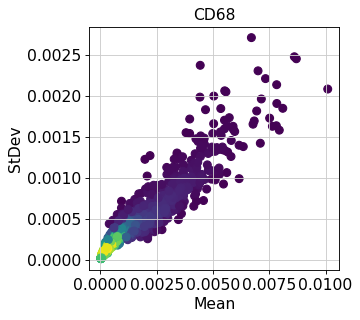

<Figure size 320x320 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt 
from scipy.stats import gaussian_kde

means = np.array(means)
stds = np.array(stds)

xy = np.vstack([means,stds])
z = gaussian_kde(xy)(xy)
print(z.shape)

fig, ax = plt.subplots()
ax.scatter(means, stds, s=50, c=z)

plt.title("CD68")
plt.ylabel("StDev")
plt.xlabel("Mean")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("CD68.png")
#fig, ax = plt.subplots()
#ax.scatter(means, stds, s=100, edgecolor='')
#plt.show()

In [20]:
""""
#probably don't load to CSV until all models
#have been filled and mean/std calculated

import csv
from csv import writer
 
with open('valuesf.csv', 'a') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(vecf)
    f_object.close()
with open('valuess.csv', 'a') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(vecs)
    f_object.close()
with open('valuesm.csv', 'a') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(vecm)
    f_object.close()

    """

'"\n#probably don\'t load to CSV until all models\n#have been filled and mean/std calculated\n\nimport csv\nfrom csv import writer\n \nwith open(\'valuesf.csv\', \'a\') as f_object:\n    writer_object = writer(f_object)\n    writer_object.writerow(vecf)\n    f_object.close()\nwith open(\'valuess.csv\', \'a\') as f_object:\n    writer_object = writer(f_object)\n    writer_object.writerow(vecs)\n    f_object.close()\nwith open(\'valuesm.csv\', \'a\') as f_object:\n    writer_object = writer(f_object)\n    writer_object.writerow(vecm)\n    f_object.close()\n\n    '

In [399]:
#Fibroblast, smooth muscle, myeloid
fibroblast = ["DCN", "GSN", "PDGFRA"]
smooth = ["MYH11", "TAGLN", "ACTA2"]
myeloid = ["CD14", "C1QA", "CD68"]

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see TODO.

For example, a 1-vs-1 DE test is as simple as:

We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

We now extract top markers for each cluster using the DE results.

We can also visualize the scVI normalized gene expression values with the `layer` option.

In [14]:
#to corroborate markers
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

In [16]:
de_df = model.differential_expression(
    groupby="cell_type", 
    group1="Myeloid", 
    group2="Smooth_muscle_cells"
)
de_df.head()


DE...: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
ACTA2,0.9998,0.0002,8.516943,0.000209,0.021659,0.0,0.25,-7.032821,-7.005724,1.961830,-13.479710,0.205027,0.074190,13.970368,0.065831,0.751950,2.114226,248.179764,True,Myeloid vs Smooth_muscle_cells
MS4A6A,0.9996,0.0004,7.823621,0.004653,0.000074,0.0,0.25,6.676530,6.593922,2.171337,-0.809321,13.737561,1.948803,0.004680,0.594566,0.004680,47.831718,0.304685,True,Myeloid vs Smooth_muscle_cells
MS4A4A,0.9994,0.0006,7.417964,0.001920,0.000034,0.0,0.25,6.389101,6.276639,2.315374,-1.344044,14.905746,0.899685,0.003120,0.381400,0.003120,19.409658,0.073182,True,Myeloid vs Smooth_muscle_cells
CALD1,0.9992,0.0008,7.130086,0.001422,0.022258,0.0,0.25,-4.332909,-4.359652,1.326091,-9.202156,0.178064,0.111808,8.237137,0.082550,0.900156,4.560734,242.169189,True,Myeloid vs Smooth_muscle_cells
IGFBP5,0.9990,0.0010,6.906745,0.000230,0.007490,0.0,0.25,-5.511497,-5.609962,1.846183,-12.000252,1.952321,0.026123,3.592825,0.024033,0.556942,1.202468,87.492805,True,Myeloid vs Smooth_muscle_cells


In [19]:
de_df = model.differential_expression(
    groupby="cell_type", 
)
de_df.head()

DE...: 100%|██████████| 11/11 [00:37<00:00,  3.41s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
FASN,0.9992,0.0008,7.130086,0.012678,0.000145,0.0,0.25,6.752458,6.865678,2.080543,-1.885006,14.140721,7.062068,0.025086,0.841379,0.022167,129.074371,1.084626,True,Adipocytes vs Rest
PTPRF,0.9990,0.0010,6.906745,0.003039,0.000070,0.0,0.25,6.252528,6.195706,2.255522,-2.676909,14.256748,1.468965,0.011300,0.600000,0.010651,26.615402,0.438129,True,Adipocytes vs Rest
GYG2,0.9986,0.0014,6.569875,0.002164,0.000030,0.0,0.25,7.228670,6.848175,3.392981,-2.433887,20.362829,1.386207,0.002649,0.462069,0.002595,22.767191,0.110073,True,Adipocytes vs Rest
SLC19A3,0.9986,0.0014,6.569875,0.004304,0.000048,0.0,0.25,7.746510,7.728087,3.002410,-1.650579,18.112562,2.910343,0.004650,0.572414,0.004325,51.325165,0.268085,True,Adipocytes vs Rest
CIDEC,0.9986,0.0014,6.569875,0.001999,0.000023,0.0,0.25,7.212508,7.226597,2.517421,-2.451948,17.347637,1.137931,0.001406,0.510345,0.001406,21.809771,0.057564,True,Adipocytes vs Rest
